In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import sys

# use this to hide the red warning boxes
# Only use once you know they aren't significant
import warnings
warnings.filterwarnings('ignore')

# use seaborn plot styles
sns.set()

# increase max columns so we can see everything.
# Jupyter is nice in that it puts the table into a scrolling window
pd.set_option('display.max_columns', None)

# Processing variant data table

Process the VEP variant table.
Data cleanining and putting into correct categories.

## Inputs

* unfiltered_variants.tsv
 * Merged list of all variants from all samples in the DDD CAP dataset
 * Annotated with VEP
 * Includes DDD static ID for proband, mother, and father

## Outputs

* variants_processed.pickle
 * Variants after filtering (see summary)
* variants_processed_with_zscore.pickle
 * As above, but includes a Z-score indicating the significance of the difference between the cohort Af and GnomAD 
* variant_frequencies.pickle
 * Unique list of variants
 * Includes the frequency within this data set
* filtering_stats.pickle
 * Counts of variant types during the steps of filtering
 * So we can still plot this without repeating the whole analysis

## Summary

* Data filtered to include only:
 * Variants with GnomAD Frequency < 5%
 * Variants with a known maternal genotype (e.g. not 0/0 or ./. in the mother of the trio)
 * Once of each variant from the same mother where duplicated because of multiple children.
 * "HIGH" or "MODERATE" predicted impact

In [2]:
# Maximum GnomAD frequency - remove all variants above this
MAX_GNOMAD = 0.05

In [3]:
def prep_dataframe(TSV_FILE) -> pd.DataFrame:
    """
    Read the dataframe and perform initial cleaning of data
    
    e.g. convert to the correct data types
    """
    
    # Define converter functions
    def float_converter(var):
        """Converts a string to a float (if possible)"""
        try:
            return pd.np.float(var)
        except ValueError:
            return pd.np.nan
        
    def gt_converter(gt):
        """Convert a genotpye (1/0, 1/1, etc.) to a numerical allele count"""
        if gt in ["0/0"]:
            return 0
        elif gt in ["./."]:
            return -1
        elif gt in ["0/1", "1/0", "./1", "1/."]:
            return 1
        elif gt in ["1/1"]:
            return 2
        else:
            return pd.np.nan
        
    # Specify the columns to import, rather than importing and then dropping
    columns = ["CHROM", "POS", "ID", "GENE", "PROTEIN", "HGVSc", "HGVSp", "IMPACT", "GnomAD_AF", "ExAC_AF", "SIFT", "Polyphen", "PUBMED",
           "MAT_ID", "MAT_GT", "PAT_ID", "PAT_GT", "PRO_ID", "PRO_GT"]
    
    # Specify dtypes for each column, so we don't have to convert them later
    dtypes = {"CHROM": "category", "POS": "int", "ID": "object", "GENE": "category", "PROTEIN": "category", "HGVSc": "object", 
              "HGVSp": "object", "IMPACT": "category", "GnomAD_AF": "object", "ExAC_AF": "object", "SIFT": "object",
              "Polyphen": "object", "PUBMED": "object", "MAT_ID": "object", "MAT_GT": "category", "PAT_ID": "object", 
              "PAT_GT": "category", "PRO_ID": "object", "PRO_GT": "category"}
    
    # Set converters to work on data while importing
    converters = {"GnomAD_AF": float_converter, "ExAC_AF": float_converter, "MAT_GT": gt_converter, "PAT_GT": gt_converter, "PRO_GT": gt_converter}
    
    # DEV: Use nrows to only read the first 100,000 variants to make it more practical to work on for development
    #      Actual total variant count is over 37 million
    df = pd.read_csv(TSV_FILE, sep='\t',
                     header=0,
                     usecols=columns,
                     dtype=dtypes,
                     converters=converters
                    )
    
    
    print("Total number of variants: {}".format(len(df.ID)))
    
    # Calculate the exact cohort size, excluding duplicates
    COHORT_SIZE = df.MAT_ID.unique().shape[0]    
    COHORT_CHROMS = COHORT_SIZE * 2
    # Add the cohort size to the dataframe
    df['cohortsize'] = COHORT_CHROMS
    df['patcohort'] = df.PAT_ID.unique().shape[0] * 2
    
    print("Overall size of cohort: {} mothers".format(COHORT_SIZE))
    print("Total chromosomes: {}".format(COHORT_CHROMS))
       
    return df

In [4]:
def gather_stats(df: pd.DataFrame, step: str) -> pd.DataFrame:
    """
    Calculate various bits of information about the given dataframe, so we don't end up with it split
    all over the place like it currently is.
    
    Should be appended to the existing dataframe so that each additional run adds a new column.
    Might need a name column, so we can keep track. e.g. Update after doing a filter
    """
    dfitems = {'index': step, 'name': step, 'varcount': None, 'varsperchrom': None, 'impacts': None}
    
    # NOTE: values have to be contained in a list to be read into the DataFrame as the same type
    dfitems['varcount'] = [len(df.CHROM)]
    dfitems['varsperchrom'] = [df.CHROM.value_counts().sort_index()]
    dfitems['HIGH'] = [df.IMPACT.value_counts()['HIGH']]
    for impact in df.IMPACT.value_counts().index.to_list():
        dfitems[impact] = [df.IMPACT.value_counts()[impact]]
    
    return pd.DataFrame(dfitems).set_index('index')

Data cleaning and interpreting
-------------------------------------------

Setting the appropriate data types can help with downstream analysis, and also reduce the memory requirements for the data frame. Some of this might be possible to do while actually reading the file, which would probably be easier.

* Replace X and Y in CHROM column with 23 and 24, so this column is purely numerical
* Set numerical columns as appropriate (e.g. CHROM and POS are whole integers, AF columns are float.
* Set categorical data types to save space

In [5]:
# Can this be integrated with the above so the final dataframe has the counts in it *before* filtering?
# Or does it just need to be run before filtering?
def calculate_frequencies(df):
    try:
        df = pd.read_pickle('Processed_data/variants_processed_with_zscore.pickle')
        variants = pd.read_pickle('Processed_data/variant_frequencies.pickle')
    except FileNotFoundError:    
        # Get a unique list of variants
        variants = df[['ID', 'GENE', 'GnomAD_AF', 'ExAC_AF', 'IMPACT', 'cohortsize']].drop_duplicates().sort_values('ID')

        # Add the number of times each variant occurs in the main dataset
        variants = variants.join(df.groupby('ID')['MAT_GT'].sum(), on='ID', rsuffix='_')
        variants = variants.join(df.ID.value_counts(), on='ID', rsuffix='_')
        variants = variants.rename(columns={'ID_': 'COHORT_AC'})

        # Calculate the allele frequency from this allele count and the cohort size
        # DEV: This needs to account for zygosity and chrom count
        variants['COHORT_AF'] = variants['COHORT_AC'] / variants['cohortsize']

        variants['AF_DIFF'] = variants.COHORT_AF - variants.GnomAD_AF
        
        # Add a Z-score column to the variant data
        # Z-score is the number of stdevs away from the expected GnomAD allele frequency
        stdev = variants.AF_DIFF.std()
        variants['Z_score'] = variants.AF_DIFF / stdev
        
        # Add the Z-score value to the main datafram
        # create a merge-able dataframe with the Z-score
        df = pd.merge(df, variants[['ID', 'Z_score']], on='ID')

        variants.to_pickle('Processed_data/variant_frequencies.pickle')
        df.to_pickle('Processed_data/variants_processed_with_zscore.pickle')
        
    return variants

In [6]:
# Processing the main variant file is very slow and requires a lot of RAM
# so if the final output is stored in Processed_data just load that instead
try:
    df = pd.read_pickle('Processed_data/variants_processed.pickle')
    stats = pd.read_pickle('Processed_data/filtering_stats.pickle')    
except FileNotFoundError:
    # Load the data from the TSV file
    df = prep_dataframe('../04_Process_Samples/Processed_data/unfiltered_variants.tsv')
    
    
    # Record the initial variant count before any processing
    raw_varcount = len(df.CHROM)
    stats = gather_stats(df, "raw")
    # remove duplicate samples (i.e. where a maternal sample is included from multiple probands)
    df = df[df.duplicated(['MAT_ID', 'POS']) == False]
    deduplicated_varcount = len(df.CHROM)    
    stats = stats.append(gather_stats(df, "deduplicated"))
    # Remove uncertain genotype
    # NOTE: These values have already been converted to genotype counts by the gt_converter function
    #       when loading the TSV file
    df = df[df['MAT_GT'] != -1]
    stats = stats.append(gather_stats(df, "remove_mat_uncertain"), sort=False)
    # Remove known wild-type genotypes
    df = df[df['MAT_GT'] != 0]
    stats = stats.append(gather_stats(df, "mat_only"), sort=False)
    # NOTE: are there variants without a gnomad frequency and if so what happens to them here?
    df = df[df['GnomAD_AF'] <= MAX_GNOMAD]
    stats = stats.append(gather_stats(df, "gnomad"), sort=False)
    df = df[df['IMPACT'] != 'MODIFIER']
    stats = stats.append(gather_stats(df, "no_modifiers"), sort=False)
    df = df[df['IMPACT'] != 'LOW']
    stats = stats.append(gather_stats(df, "no_low_impact"), sort=False)

    # Calcualte the per-variant frequencies from this dataset
    variants = calculate_frequencies(df)
    
    # Save to pickles
    df.to_pickle('Processed_data/variants_processed.pickle')
    stats.to_pickle('Processed_data/filtering_stats.pickle')

Variant counts at each filtering step


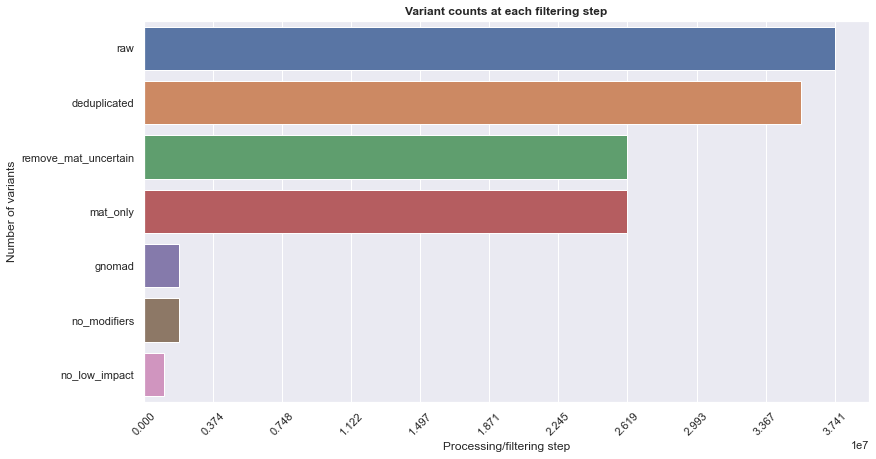

In [7]:
# Plot raw vs. deduplicated variants
# DEV: replace this with the stats and plots methods
fig, axes = plt.subplots(figsize=(13,7))
ax = sns.barplot(y='name', x='varcount', data=stats)
ax.set_title("Variant counts at each filtering step", fontweight='bold')
ax.set_ylabel("Number of variants")
ax.set_xlabel("Processing/filtering step")
plt.xticks(rotation='45')
# Calculate the tick interval automatically from the raw number of variants
ax.xaxis.set_major_locator(ticker.MultipleLocator(stats.varcount.max()/10))

print("Variant counts at each filtering step")

In [8]:
stats

name  varcount  \
index                                                  
raw                                    raw  37412661   
deduplicated                  deduplicated  35584887   
remove_mat_uncertain  remove_mat_uncertain  26177889   
mat_only                          mat_only  26172717   
gnomad                              gnomad   1915194   
no_modifiers                  no_modifiers   1915155   
no_low_impact                no_low_impact   1089214   

                                                           varsperchrom  \
index                                                                     
raw                   1     3693306
10    1524760
11    2614174
12  ...   
deduplicated          1     3516389
10    1452233
11    2486437
12  ...   
remove_mat_uncertain  1     2604411
10    1071835
11    1854889
12  ...   
mat_only              1     2603847
10    1071801
11    1854165
12  ...   
gnomad                1     190747
10     74638
11    121906
12     ...   
no_modifiers          1     190747
10     74635
11    121902
12     ...   
no_low_impact         1     113984
10     41541
11     73816
12     ...   

                     impacts    HIGH       LOW  MODERATE  MODIFIER  
index                                                               
raw                     None  682411  19036628  17675243     18379  
deduplicated            None  635190  18136589  16795578     17530  
remove_mat_uncertain    None  459522  13425503  12276405     16459  
mat_only                None  458378  13424922  12272958     16459  
gnomad                  None   46629    825941   1042585        39  
no_modifiers            None   46629    825941   1042585         0  
no_low_impact           None   46629         0   1042585         0

Data visualisations
---------------------------

Basic exporatory plots for the data - sanity checking etc.

### CHROM column
 * Check chromosomes are all in allowed values, and that X & Y have been replaced with numerical values (this is for ease of processing
 * Plot variant counts per chromosome

Includes log scale to show chroms with low variant numbers (e.g. Y) more clearly
NOTE: there *are* some variants on the Y but not many. Unsurprising since we're filting to those present in the mother!
Correllation between raw and filtered number: 0.992


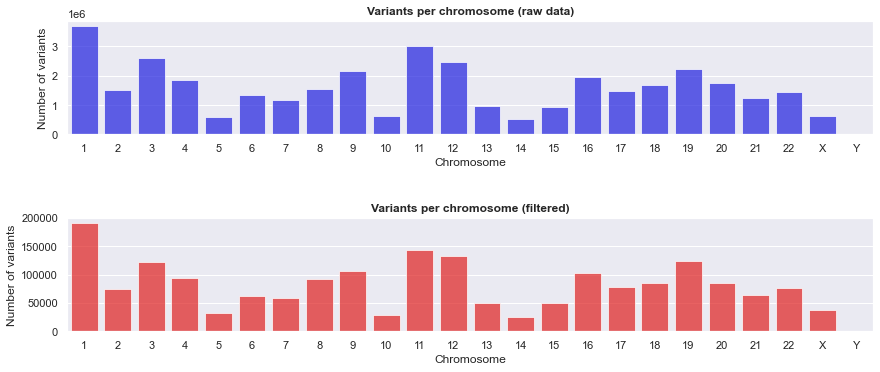

In [10]:
# List of valid chromosomes (X and Y should be cast to 23 and 24 on opening)
chroms = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]
    
# Use this list to label the plots with X and Y
chrom_labels = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,"X","Y"]

# Bar plot
# NOTE: log y axis used to show lower frequency chroms
f, axes = plt.subplots(2, 1, figsize=(12,5))
plt.tight_layout(h_pad=5.0)
ax = sns.barplot(y=stats.loc['raw']['varsperchrom'], x=list(stats.loc['raw']['varsperchrom'].index), data=stats.loc['raw'], color='blue', alpha=0.7, ax=axes[0])
ax.set_title("Variants per chromosome (raw data)", fontweight='bold')
ax.set_ylabel("Number of variants")
ax.set_xlabel("Chromosome")
ax.set_xticklabels(chrom_labels)

ax2 = sns.barplot(y=stats.loc['gnomad']['varsperchrom'], x=list(stats.loc['raw']['varsperchrom'].index), data=stats.loc['gnomad'], color='red', alpha=0.7, ax=axes[1])
ax2.set_title("Variants per chromosome (filtered)", fontweight='bold')
ax2.set_ylabel("Number of variants")
ax2.set_xlabel("Chromosome")
ax2.set_xticklabels(chrom_labels)

print("Includes log scale to show chroms with low variant numbers (e.g. Y) more clearly")
print("NOTE: there *are* some variants on the Y but not many. Unsurprising since we're filting to those present in the mother!")
print("Correllation between raw and filtered number: {:.3f}".format(stats.loc['raw']['varsperchrom'].corr(stats.loc['gnomad']['varsperchrom'])))

### IMPACT column
* Just a basic plot again, breaking down variants by predicted severity of impact

NOTE: The axes are NOT the same scale


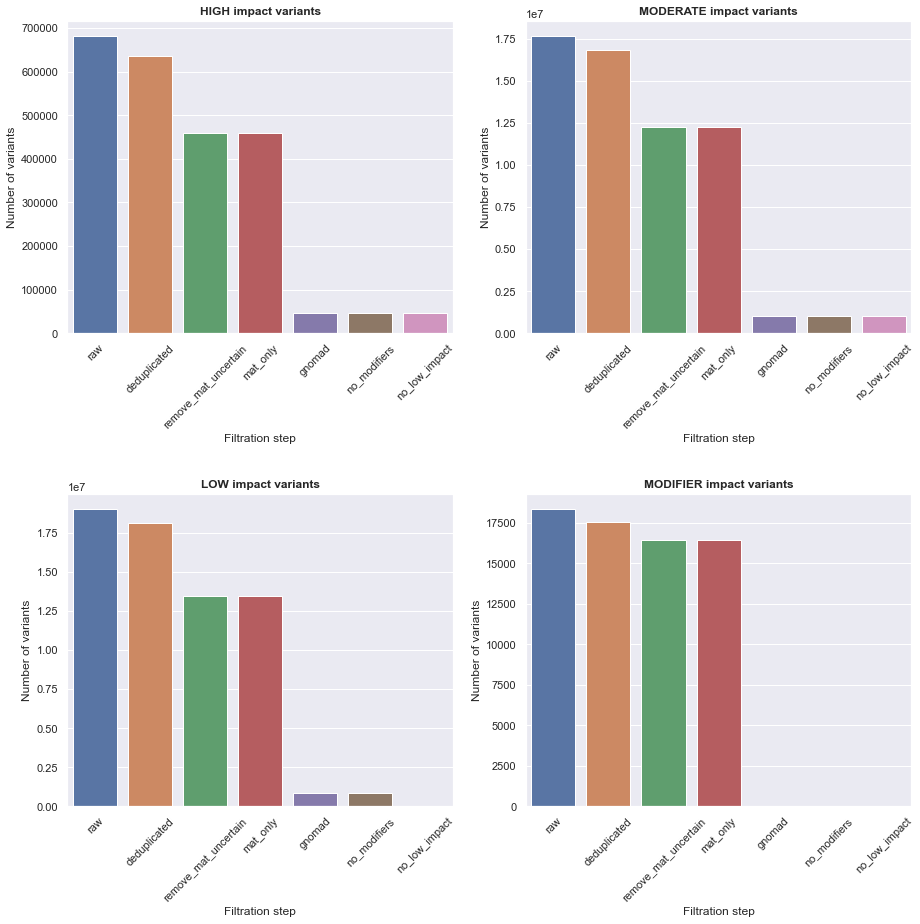

In [11]:
# Plot variant counts broken down by type/impact
try:
    f, axes = plt.subplots(2, 2, figsize=(13,13))#, sharey=True)
    ax = sns.barplot(x='name', y='HIGH', data=stats, ax=axes[0][0])
    ax.set_title("HIGH impact variants", fontweight='bold')
    ax.set_ylabel("Number of variants")
    ax.set_xlabel("Filtration step")
except ValueError:
    # For use in testing when there might not be any variants with this impact
    pass

try:
    ax2 = sns.barplot(x='name', y='MODERATE', data=stats, ax=axes[0][1])
    ax2.set_title("MODERATE impact variants", fontweight='bold')
    ax2.set_ylabel("Number of variants")
    ax2.set_xlabel("Filtration step")
except ValueError:
    # For use in testing when there might not be any variants with this impact
    pass

try:
    ax3 = sns.barplot(x='name', y='LOW', data=stats, ax=axes[1][0])
    ax3.set_title("LOW impact variants", fontweight='bold')
    ax3.set_ylabel("Number of variants")
    ax3.set_xlabel("Filtration step")
except ValueError:
    # For use in testing when there might not be any variants with this impact
    pass

try:
    ax4 = sns.barplot(x='name', y='MODIFIER', data=stats, ax=axes[1][1])
    ax4.set_title("MODIFIER impact variants", fontweight='bold')
    ax4.set_ylabel("Number of variants")
    ax4.set_xlabel("Filtration step")
except ValueError:
    # For use in testing when there might not be any variants with this impact
    pass

# rotated the x-axis tick labels for each subplot
for ax in f.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)
    
# add some spacing
plt.tight_layout(h_pad=3)

print("NOTE: The axes are NOT the same scale")

### Allele frequency enrichement

Are there variants in the dataset that are occuring more frequently than we would expect from the GnomAD population frequencies?

In [12]:
try:
    df = pd.read_pickle('Processed_data/variants_processed_with_zscore.pickle')
    variants = pd.read_pickle('Processed_data/variant_frequencies.pickle')
except FileNotFoundError:    
    # Subset to just the allele frequencies and remove duplicates so we have a unique list
    # Duplicates meaning same parents from multiple trios
    variants = df[['ID', 'GENE', 'GnomAD_AF', 'ExAC_AF', 'IMPACT', 'cohortsize']].drop_duplicates().sort_values('ID')
    # Create a column with the *chromosome* count of each variant, not the sample count as before
    df['MAT_COUNT'] = df['MAT_GT'].replace(to_replace='1/0', value=1).replace(to_replace='0/1', value=1).replace(to_replace='1/1', value=2).replace(to_replace='./.', value=0).replace(to_replace='0/0', value=0)
    df['PAT_COUNT'] = df['PAT_GT'].replace(to_replace='1/0', value=1).replace(to_replace='0/1', value=1).replace(to_replace='1/1', value=2).replace(to_replace='./.', value=0).replace(to_replace='0/0', value=0)
    
    # Get the number of times each variant occurs in the main dataset
    variants = variants.join(df.groupby('ID')['MAT_COUNT'].sum(), on='ID', rsuffix='_')
    variants = variants.join(df.ID.value_counts(), on='ID', rsuffix='_')
    variants = variants.rename(columns={'ID_': 'COHORT_AC'})

    # Calculate the allele frequency from this allele count and the cohort size
    # DEV: This needs to account for zygosity and chrom count
    variants['COHORT_AF'] = variants['COHORT_AC'] / variants['cohortsize']

    variants['AF_DIFF'] = variants.COHORT_AF - variants.GnomAD_AF
    # Add a Z-score column to the variant data
    stdev = variants.AF_DIFF.std()
    variants['Z_score'] = variants.AF_DIFF / stdev
    # Add the Z-score value to the main datafram
    # create a merge-able dataframe with the Z-score
    df = pd.merge(df, variants[['ID', 'Z_score']], on='ID')

    variants.to_pickle('Processed_data/variant_frequencies.pickle')
    df.to_pickle('Processed_data/variants_processed_with_zscore.pickle')

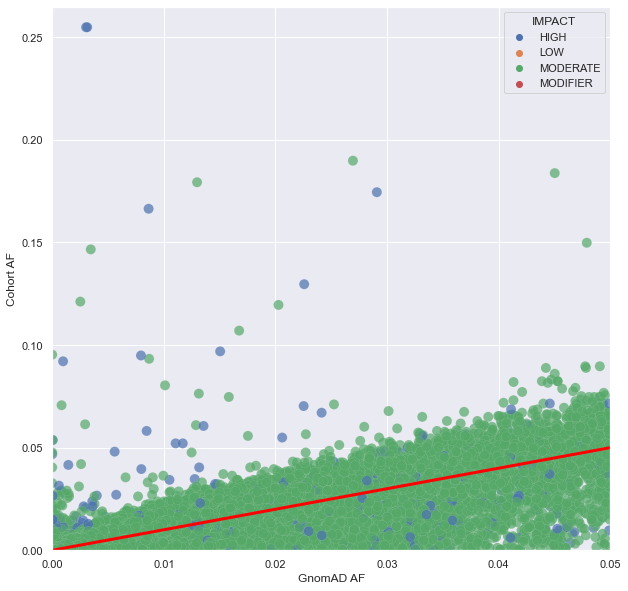

In [13]:
# This is a slightly more complex plot
# Allele frequency in this cohort vs. gnomAD frequency
# plt.plot adds a line at equality between the two. Above = higher in this cohort
plt.figure(figsize=(10, 10))
ax = sns.scatterplot(x='GnomAD_AF', y='COHORT_AF', data=variants, alpha=0.7, s=100, linewidth=0.1, hue='IMPACT')
ax.set_ylabel("Cohort AF")
ax.set_xlabel("GnomAD AF")
axislimit = max([max(variants['GnomAD_AF']), max(variants['COHORT_AF'])])+0.01
plt.ylim(0,axislimit)
plt.xlim(0,0.05)#axislimit)
plt.plot([0, axislimit], [0., axislimit], 'k-', lw=3, color="red")
plt.show()

In [14]:
variants[variants.Z_score > 10].sort_values("Z_score", ascending=False)

ID      GENE  GnomAD_AF  \
128044                                 6:32549579TG>T  HLA-DRB1   0.003034   
128045                                 6:32549584C>CT  HLA-DRB1   0.003135   
306294                             13:100622667TGGC>T      ZIC5   0.012980   
54618                                  15:90294281A>C     MESP1   0.026950   
5087                                 2:214012403CAA>C     IKZF2   0.008639   
54620                                 15:90294304C>CG     MESP1   0.029090   
156755                                  6:32609312A>C  HLA-DQA1   0.003455   
100203                            6:32552093ACCGCAC>A  HLA-DRB1   0.045030   
233424                                 1:145039594T>C   PDE4DIP   0.002521   
149208                                 1:145074975G>A   PDE4DIP   0.022580   
71606                                 6:1611802G>GGGC     FOXC1   0.047900   
52924                                  14:22476144C>T    TRAV19   0.020280   
70588                    5:60628574CCGGCCGCAACCTCGG>C    ZSWIM6   0.000000   
43290                                 6:32489745CGG>C  HLA-DRB5   0.000974   
43296                                   6:32551939G>T  HLA-DRB1   0.016750   
43298                                  6:32551954CG>C  HLA-DRB1   0.007955   
261006                                 1:145014199C>A   PDE4DIP   0.008685   
43297                                  6:32551947CG>C  HLA-DRB1   0.015050   
344823                                 1:145021150T>C   PDE4DIP   0.010110   
128040                                  6:32489881G>T  HLA-DRB5   0.000839   
52761                           13:112722435ATGGGCG>A      SOX1   0.013140   
14413                                8:65493617T>TGGC   BHLHE22   0.015830   
184702                                  6:32609299A>C  HLA-DQA1   0.002948   
96606                               3:113376113C>CTGT  KIAA2018   0.000010   
96605                                 3:113376112GC>G  KIAA2018   0.000056   
1056986  5:7757683TGGCCGTGTTCAACATGGTAAGTCCCAGAGCAC>T     ADCY2   0.008460   
22127                              13:108518686TCTG>T   FAM155A   0.012880   
10839                                 6:31238931G>GTC     HLA-C   0.022530   
128034                                  6:32486344T>C  HLA-DRB5   0.000000   
47707                                9:137968996GCA>G     OLFM1   0.013560   
96607                          3:113376114TGCTGCTGC>T  KIAA2018   0.000006   
292519                              2:218712886GGCT>G      TNS1   0.025250   
156435                                  6:28366151A>G   ZSCAN12   0.044240   
328233                        9:78790143GAATGGAATGA>G     PCSK5   0.024140   
742852                                2:206641245T>TA      NRP2   0.005596   
156414                                  6:27879982A>G     OR2B2   0.047760   
685456                                2:100210334CG>C      AFF3   0.011060   
156413                                  6:27879200C>A     OR2B2   0.047830   
97922                                  4:103188709C>T   SLC39A8   0.045030   
11360                             6:42989413CGCCGGG>C     RRP36   0.041340   
156423                                  6:28268824A>G     PGBD1   0.049070   
685457                            2:100210337CTGAGG>C      AFF3   0.011700   
42429                                  5:167956570G>A     FBLL1   0.000000   
40250                                      4:60294T>C    ZNF595   0.001445   
123350                              2:233243528ATGC>A      ALPP   0.002587   
202215                                 20:44582435G>T    ZNF335   0.043880   
212761                                  6:26409890G>C    BTN3A1   0.044720   
544175                           2:176995302G>GCGCACC     HOXD8   0.017540   

          ExAC_AF    IMPACT  cohortsize  MAT_GT  COHORT_AC  COHORT_AF  \
128044   0.060000      HIGH        2476     631        631   0.254847   
128045   0.060000      HIGH        2476     631        631   0.254847   
306294   

* add distance from gnomad AF
* plot histogram
* get stats
* select most different

**NOTE:** This is a selection/filtering step, it is not a test for significance. We are using the standard deviation to calculate a Z-score for each variant in order to closer investigate the most discrepant variants, NOT to indicate a probability of the variant being enriched in this cohort by anything other than chance.

Mean: -7.242382933851063e-05
STDEV: 0.00379454292123412


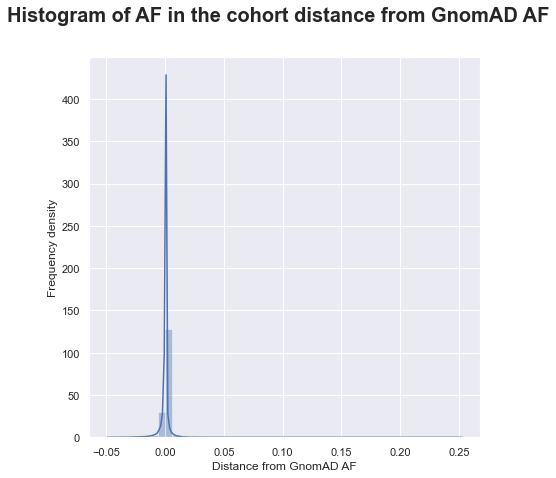

In [15]:
f, axes = plt.subplots(figsize=(7, 7))
f.suptitle('Histogram of AF in the cohort distance from GnomAD AF', fontweight='bold', fontsize=20)
ax = sns.distplot(variants.AF_DIFF, bins=50)
ax.set_ylabel("Frequency density")
ax.set_xlabel("Distance from GnomAD AF")

mean = variants.AF_DIFF.describe()['mean']
stdev = variants.AF_DIFF.describe()['std']

print("Mean: {}".format(mean))
print("STDEV: {}".format(stdev))

In [16]:
variants.shape

(167103, 11)